<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-requisites" data-toc-modified-id="Pre-requisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-requisites</a></span></li><li><span><a href="#Instructions" data-toc-modified-id="Instructions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Instructions</a></span></li><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Calculate-Locations-Statistics" data-toc-modified-id="Calculate-Locations-Statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate Locations Statistics</a></span></li><li><span><a href="#Create-In-country-Folds" data-toc-modified-id="Create-In-country-Folds-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create In-country Folds</a></span></li></ul></div>

## Pre-requisites

None

## Instructions

Households surveyed by DHS and LSMS are grouped into clusters (roughly villages). Our goal is to train models to predict the average cluster wealth-index given a satellite image of the cluster. To train our models, we assign the clusters into training (`train`), validation (`val`), and test (`test`) splits.

However, we do not arbitrarily assign clusters to splits because many clusters are located very close to each other such that their satellite images overlap. If one cluster was put in `train` and a nearby cluster was put into `test`, this may constitute "peaking" at the test set. This is not what we want. Instead, we want our model to be generalizable, able to estimate the cluster wealth-index in grographic regions that the model has not necessarily seen before.

Thus, we have to take special care that the satellite images between splits do not overlap. We do this through 2 separate approaches: "out-of-country" and "in-country". For "**out-of-country**" splits, we assign entire countries to a split, so naturally there is no overlap between splits. For "**in-country**" splits, we allow different clusters within the same country to be assigned to different splits, taking care that their satellite images have no overlap. **The point of this notebook is to create the in-country splits.**

Because the survey data is fairly limited (~20K DHS clusters, ~3K LSMS clusters), we actually use cross-validated training. We assign the clusters to 1 of 5 folds labeled `['A', 'B', 'C', 'D', 'E']` such that the folds are non-overlapping. Given the 5 folds, we create 5 different sets of train/val/test splits, where each set is labeled by the name of its `test` fold:

```
A) test  = {A}
   val   = {B}
   train = {C, D, E}

B) test  = {B}
   val   = {C}
   train = {D, E, A}

...

E) test  = {E}
   val   = {A}
   train = {B, C, D}
```

This notebook creates 2 Python pickle files: `data/dhs_incountry_folds.pkl` and `data/lsms_incountry_folds.pkl`. Each of these files contains a pickle'd Python dictionary which can be loaded as follows:

```python
with open('data/dhs_incountry_folds.pkl', 'rb') as f:
    dhs_incountry_folds = pickle.load(f)
```

The dictionary has type `Dict[str, Dict[str, np.ndarray]` such that `dhs_incountry_folds[f][s]` returns an array of indices corresponding to split `s` of fold `f`. The indices correspond to 0-indexed rows from `data/dhs_clusters.csv` and `data/lsms_clusters.csv`.

```python
dhs_incountry_folds = {
    'A': {'test':  array([   28,    29,    35, ..., 19662, 19664, 19667]),
          'train': array([    2,     3,     4, ..., 19663, 19665, 19668]),
          'val':   array([    0,     1,     8, ..., 19643, 19659, 19666])},
    ...
    'E': {'test':  array([    2,     3,     4, ..., 19653, 19656, 19663]),
          'train': array([    0,     1,     6, ..., 19665, 19666, 19668]),
          'val':   array([   28,    29,    35, ..., 19662, 19664, 19667])}}
```

## Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2

# change directory to repo root, and verify

DATA_DIR = '/mimer/NOBACKUP/groups/globalpoverty1/data/'

In [2]:
import pickle
from pprint import pprint

import numpy as np
import pandas as pd
import json
import os
from shapely.geometry import shape, Point

import sys
sys.path.append('/cephyr/users/markpett/Alvis/satellite_poverty_prediction/')

from preprocessing.create_folds import (
    create_folds,
    create_split_folds,
    save_folds,
    verify_folds)

In [3]:
FOLDS = ['A', 'B', 'C', 'D', 'E']
MIN_DIST = 0.096198  # see how this value is computed below

Create folder for saving folds in

In [4]:
fold_dir = os.path.join(DATA_DIR, 'folds')
if not os.path.isdir(fold_dir):
    os.mkdir(fold_dir)

## Remove points to break chains

Some regions contain so many points that the clusters become very large. I.e. all of the points in Egypt would be assigned to a single cluster, which makes the splits very unevenly distributed. To combat this, we remove some points to break the chain of overlapping images.

In [5]:
# Load files
dhs_df = pd.read_csv(DATA_DIR + 'dhs_clusters.csv', float_precision='high', index_col=False)

with open(DATA_DIR + 'remove_regions.json') as f:
    remove_regions = json.load(f)

In [6]:
def point_in_remove_regions(row):
    # construct point based on lon/lat returned by geocoder
    point = Point(row['lon'], row['lat'])
    
    # check each remove region to see if it contains the point
    for feature in remove_regions['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return True
    return False

remove_points = dhs_df.apply(point_in_remove_regions, axis=1)

print(f'Removes {sum(remove_points)} out of {len(dhs_df)} clusters.')

Removes 419 out of 57195 clusters.


## Calculate Locations Statistics

We want to group our surveyed clusters into 5 folds such that there is absolutely no overlap between the satellite images from different folds. In other words, if any part of an image *i1* covers the same geographic area as another image *i2*, then we must put the clusters corresponding to *i1* and *I2* into the same fold.

We have the (lat, lon) coordinates for each cluster, so our approach is to determine the threshold "radius" around each cluster that would be considered part of the same fold. We know that our satellite images have 30m/px resolution, and our models use `224*224px` center crops of the images. This means that each image has a side length of 30m/px * 224px = **6.72km**. Thus, we try to convert 6.72km to degrees (lat, lon).

Note that the degrees longitude corresponding to a given East-West distance (in meters) changes depends on the latitude. Thus, converting between traditional units of distance (e.g., meters) and degrees lat/lon is non-trivial. This section calculates the maximum degrees (lat, lon) equivalent to 6.72km at the location of any cluster in our dataset.

The results computed should match the following:

|                                                | DHS
|-----------------------------------------------:|-----------:|
| minimum latitude                               | -34.463232
| maximum latitude                               |  35.858894
| minimum longitude                              | -17.497956
| maximum longitude                              |  50.457728
| maximum image side-length in degrees latitude  |   0.060570
| maximum image side-length in degrees longitude |   0.074735

This means that for the purpose of deciding image overlap, we assume each satellite image to have width=0.074735° and height=0.060570°. Because images may overlap in corners, we consider any two images within $$\sqrt{0.060570^2 + 0.074735^2} = 0.096198$$ degrees (lat, lon) to be overlapping. This is the value of the `MIN_DIST` constant above.

In [7]:
RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

def get_lon_for_distance(lat: float, d: float) -> float:
    '''Calculates the degrees longitude for some East-West distance at a given latitude.

    Makes (imperfect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees longitude <= returned value

    Args
    - lat: float, latitude in degrees
    - d: float, distance in km

    Returns
    - lon: float, approximate degrees longitude
    '''
    lat = np.abs(lat) * np.pi / 180.0  # convert to radians
    r = RADIUS_EARTH * np.cos(lat)  # radius at the given lat
    lon = d / r
    lon = lon * 180.0 / np.pi  # convert to degrees
    return lon

def get_lat_for_distance(d: float) -> float:
    '''Calculates the degrees latitude for some North-South distance.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees latitude <= returned value

    Args
    - d: float, distance in km

    Returns
    - lat: float, approximate degrees latitude
    '''
    lat = d / RADIUS_EARTH  # in radians
    lat = lat * 180.0 / np.pi  # convert to degrees
    return lat

def print_loc_stats(locs: np.ndarray) -> None:
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon] in degrees
        assumes lat values are + for N, - for S
        assumes lon values are + for E, - for W
    '''
    min_lat, min_lon = np.min(locs, axis=0)
    max_lat, max_lon = np.max(locs, axis=0)
    print(f'Lat. min: {min_lat:.6f}, max: {max_lat:.6f}')
    print(f'Lon. min: {min_lon:.6f}, max: {max_lon:.6f}')
    print()

    # get maximum lat/lon side-lengths for a 224x224 pixel image at 30m / px
    side_distance = 224 * 30 / 1000
    farthest_lat = max(abs(min_lat), abs(max_lat))
    side_lat = get_lat_for_distance(d=side_distance)
    side_lon = get_lon_for_distance(lat=farthest_lat, d=side_distance)
    print(f'maximum side_lat: {side_lat:.6f}')
    print(f'maximum side_lon: {side_lon:.6f}')

Get only "clean" locations that shouldn't be dropped

In [8]:
dhs_locs = dhs_df[['lat', 'lon']].values
clean_dhs_locs = dhs_locs[~remove_points]
print_loc_stats(clean_dhs_locs)

Lat. min: -34.463232, max: 35.858894
Lon. min: -17.497956, max: 50.457728

maximum side_lat: 0.060570
maximum side_lon: 0.074735


## Create In-country Folds

Using the DBSCAN algorithm, we group the survey clusters such that each group has a minimum distance of `MIN_DIST` from every other group. These are called "in-country" folds because different clusters from same country may be split across different folds. This is in contrast to the "out-of-country" (OOC) folds where the countries themselves are assigned to different folds.

num clusters: 4066
num outliers: 6653
max cluster size (excl. outliers): 2001


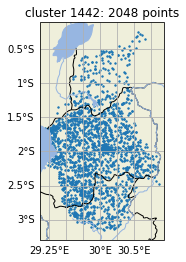

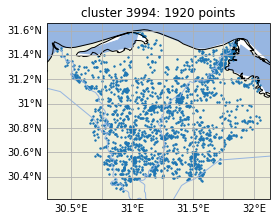

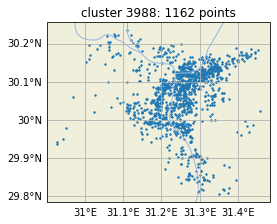

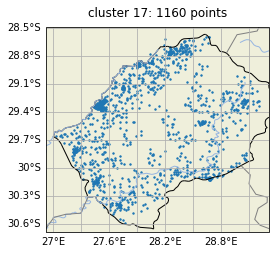

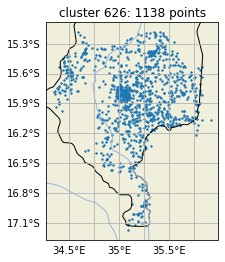

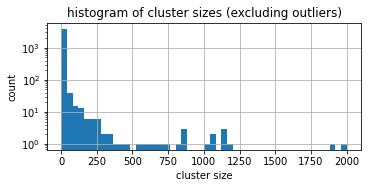

Size of each fold
{'A': 11356, 'B': 11355, 'C': 11355, 'D': 11355, 'E': 11355}
Minimum distance between each pair of folds
A B 0.09635244480943116
A C 0.0961997538458332
A D 0.09640786735839876
A E 0.09621279791609637
B C 0.09624095396451579
B D 0.09631040779686083
B E 0.09625651169532883
C D 0.09620414697925943
C E 0.09620385985325813
D E 0.0962101197001347


In [9]:
clean_folds = create_folds(
    locs=clean_dhs_locs,
    min_dist=MIN_DIST,
    fold_names=FOLDS,
    plot_largest_clusters=5)

verify_folds(
    folds=clean_folds,
    locs=clean_dhs_locs,
    min_dist=MIN_DIST,
    max_index=len(clean_dhs_locs))

Transform indices back to the same format as the dataframe

In [10]:
keep_indices = np.where(~remove_points)[0]
dhs_incountry_test_folds = {}
for fold in FOLDS:
    dhs_incountry_test_folds[fold] = keep_indices[clean_folds[fold]]

Save train, val and test set for each fold

In [11]:
dhs_incountry_folds = create_split_folds(
    test_folds=dhs_incountry_test_folds,
    fold_names=FOLDS)

save_folds(
    folds_path=os.path.join(fold_dir, 'incountry.pkl'),
    folds=dhs_incountry_folds,
    check_exists=True)

The LSMS folds used in this project were originally created from a list of 3020 clusters, before filtering out clusters that only appeared in one survey. (For LSMS, we wanted to study changes in poverty over time, so we only wanted to look at clusters that appeared in at least two surveys.)

DBSCAN is a greedy algorithm, so its output depends on the order (and the number) of (lat, lon) coordinates given. Thus, while the following code cell is not incorrect, it does not match the LSMS folds we actually used in our research.

Instead, the subsequent code blocks show how to generate the same folds we used in our research from the original list of 3020 LSMS clusters.

In [12]:
import matplotlib.pyplot as plt
from utils.geo_plot import setup_ax, plot_locs

In [13]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

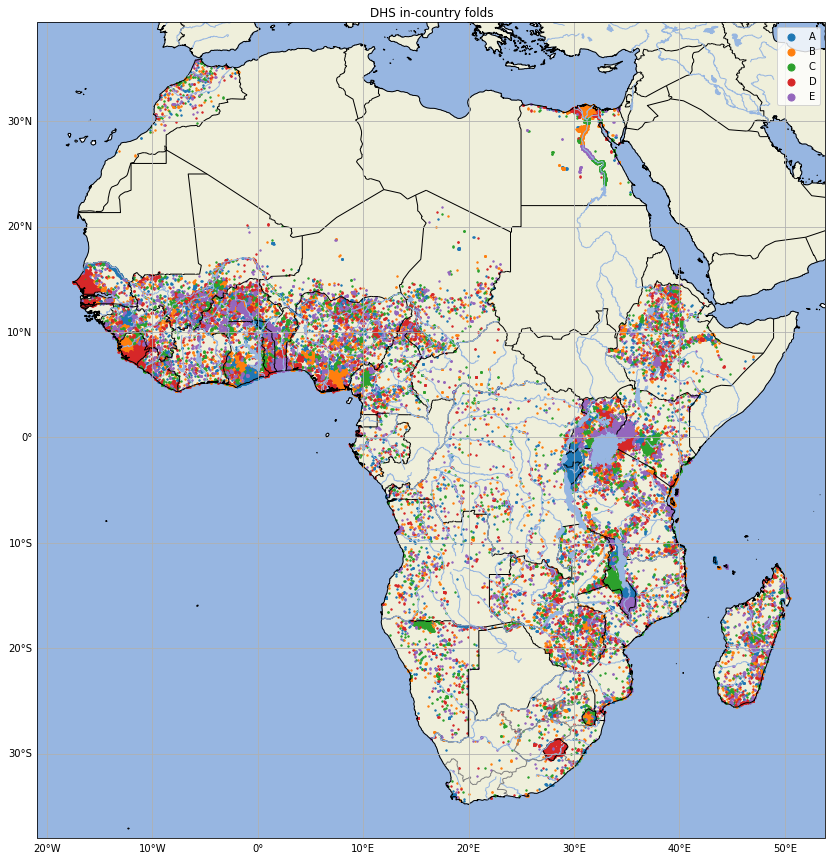

In [14]:
plot_splits({f: dhs_locs[dhs_incountry_folds[f]['test']] for f in FOLDS},
            title='DHS in-country folds')

## Out of country splits

In [15]:
sorted_countries = dhs_df.groupby('country').size().sort_values(ascending=False)

# greedily assign clusters to folds
dhs_ooc_test_folds = {f: [] for f in FOLDS}
for country in sorted_countries.index:
    # assign points in cluster c to smallest fold
    f = min(dhs_ooc_test_folds, key=lambda f: len(dhs_ooc_test_folds[f]))
    dhs_ooc_test_folds[f].extend(np.where(dhs_df['country'] == country)[0])
    
for f in FOLDS:
    dhs_ooc_test_folds[f] = np.sort(dhs_ooc_test_folds[f])
    
print('Size of each fold')
print({f: len(dhs_ooc_test_folds[f]) for f in FOLDS})

Size of each fold
{'A': 11415, 'B': 11372, 'C': 11503, 'D': 11520, 'E': 11385}


In [16]:
dhs_ooc_folds = create_split_folds(
    test_folds=dhs_ooc_test_folds,
    fold_names=FOLDS)

save_folds(
    folds_path=os.path.join(fold_dir, 'ooc.pkl'),
    folds=dhs_ooc_folds,
    check_exists=True)

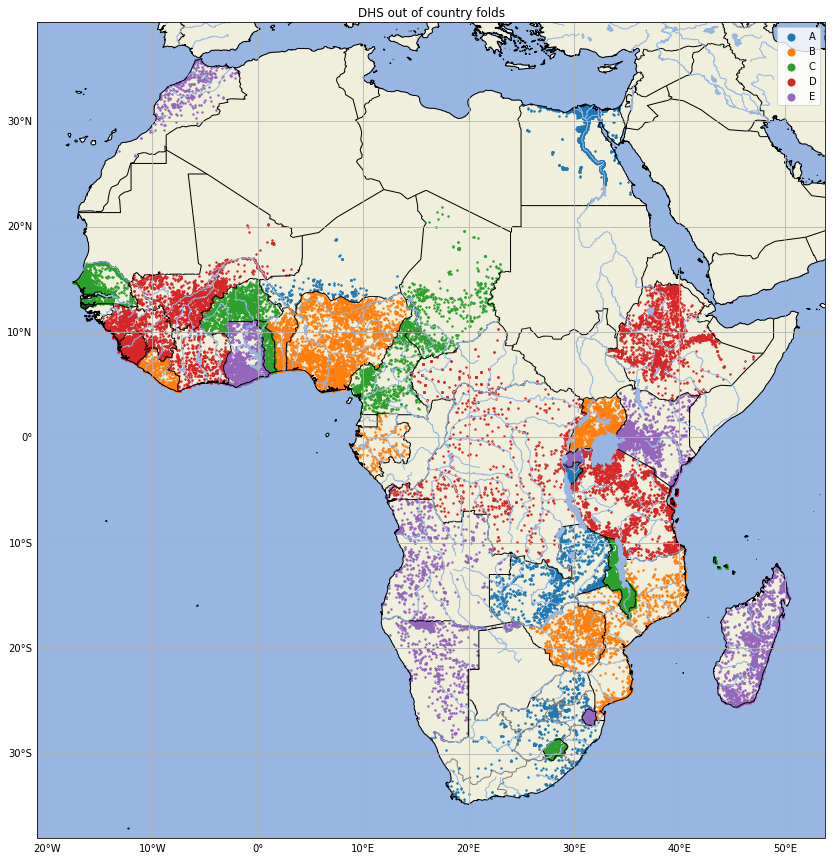

In [17]:
plot_splits({f: dhs_locs[dhs_ooc_folds[f]['test']] for f in FOLDS},
            title='DHS out of country folds')

## Out of time splits

In [18]:
dhs_df['survey_start_year']
sorted_years = dhs_df.groupby('survey_start_year').size()
sorted_years

survey_start_year
1991     142
1992     911
1993     559
1994     469
1995    1191
1996     190
1997     530
1998    1080
1999     673
2000    2566
2001     594
2003    2948
2004    1351
2005    3311
2006    1420
2007    1302
2008    4187
2009     545
2010    3602
2011    4530
2012    1826
2013    4011
2014    5775
2015    3480
2016    3907
2017    1519
2018    3613
2019     963
dtype: int64

In [19]:
def get_all_possible_chunks(a, k):
    if k == 1:
        return [[a]]
    possible_chunks = []
    for i in range(1, len(a)+2-k):
        first_chunk = a[:i]
        remainder = a[i:]
        possible_chunks_i = get_all_possible_chunks(a[i:], k-1)
        for remainder in possible_chunks_i:
            chunk_config = [first_chunk]
            chunk_config.extend(remainder)
            possible_chunks.append(chunk_config)
    return possible_chunks

values = sorted_years.values
k = len(FOLDS)
possible_chunks = get_all_possible_chunks(values, k)

ideal_chunk = sum(values)/k
best_chunk_config = None
best_squared_error = np.inf
for chunk_config in possible_chunks:
    squared_error = 0
    for chunk in chunk_config:
        squared_error += (sum(chunk) - ideal_chunk) ** 2
        
    if squared_error < best_squared_error:
        best_squared_error = squared_error
        best_chunk_config = chunk_config  

In [20]:
prev = 0
dhs_oots_test_folds = {}
survey_start_years = dhs_df['survey_start_year']

print('The timespans where split into:')
for fold, chunk in zip(FOLDS, best_chunk_config):
    curr = prev + len(chunk) - 1
    start_year = sorted_years.index[prev]
    end_year = sorted_years.index[curr]
    print(f'Fold {fold}: {start_year}-{end_year}, {sum(chunk)} clusters')
    prev = curr + 1
    
    dhs_oots_test_folds[fold] = np.where((survey_start_years >= start_year) & (survey_start_years <= end_year))[0]

The timespans where split into:
Fold A: 1991-2003, 11853 clusters
Fold B: 2004-2008, 11571 clusters
Fold C: 2009-2012, 10503 clusters
Fold D: 2013-2015, 13266 clusters
Fold E: 2016-2019, 10002 clusters


In [21]:
dhs_oots_folds = create_split_folds(
    test_folds=dhs_oots_test_folds,
    fold_names=FOLDS)

save_folds(
    folds_path=os.path.join(fold_dir, 'oots.pkl'),
    folds=dhs_oots_folds,
    check_exists=True)

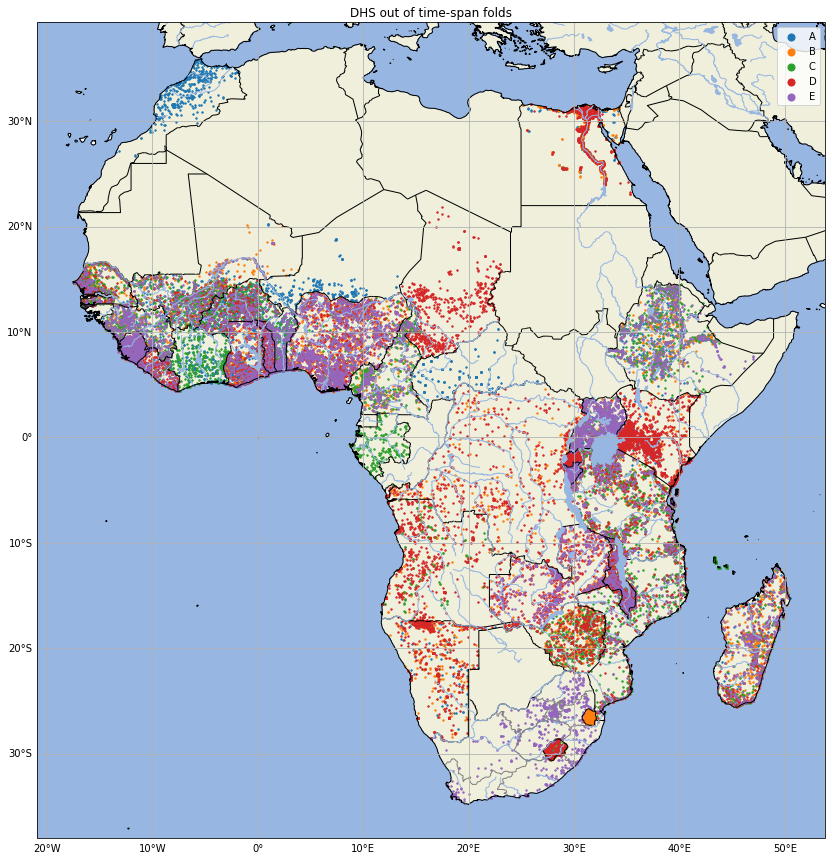

In [22]:
plot_splits({f: dhs_locs[dhs_oots_folds[f]['test']] for f in FOLDS},
            title='DHS out of time-span folds')